In [12]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [13]:
# 오전, 오후로 입력되어있는 시간 데이터를 정리해주는 함수
def ampm_calculator(df, target_columns):
  # target_column은 list형태로
  df_return = df[target_columns]
  for target in target_columns:
    df_temp = df[target_columns]
    name = target[:2]
    df_temp[name+'시'] = df_temp[target].str.split().str[-1]
    df_temp[name+'시간'] = df_temp[name+'시'].str.split(':').str[0]
    df_temp['오전오후('+name+'기준)'] = df_temp[target].str.split().str[1]
    df_temp = df_temp.astype({name+'시간':int})
    df_temp.loc[(df_temp['오전오후('+name+'기준)'] == '오후') & (df_temp[name+'시간'] != 12) , name+'시간'] += 12
    df_temp.loc[(df_temp['오전오후('+name+'기준)'] == '오전') & (df_temp[name+'시간'] == 12) , name+'시간'] -= 12
    df_return = pd.concat([df_return, df_temp.iloc[:, 4]], axis=1)
  return df_return

In [14]:
# str 형태로 되어있는 날짜 데이터를 datetime형태로 바꿔주는 함수, 오전, 오후 때문에 조금 귀찮은 과정을 거침
def str_to_datetime(df, target_columns):
  for target in target_columns:
    name = target[:2]
    df[name+'시각'] = df[target].apply(lambda x: datetime.datetime(int(x.split()[0][:4]), int(x.split()[0][5:7]), int(x.split()[0][8:]), int(x.split()[2].split(':')[0]), int(x.split()[2].split(':')[1])))
    df.loc[(df[target].str.contains('오후')) & (df[name+'시간'] != 12) , name+'시각'] += datetime.timedelta(hours=12)
    df.loc[(df[target].str.contains('오전')) & (df[name+'시간'] == 0) , name+'시각'] -= datetime.timedelta(hours=12)
    del df[target]
  return df

In [1]:
# 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
# 2019~2022년 데이터 중 일별로 나눠진 데이터 가져와서 년도별로 통합
%cd /content/drive/MyDrive/'멀티캠퍼스 5조'/2.데이터/일일이용데이터/taxi2019
data = []
df = pd.DataFrame()
for filename in tqdm(os.listdir()):
  temp_df = pd.read_csv(filename, encoding='cp949')
  df = pd.concat([df, temp_df])
data.append(df)

%cd /content/drive/MyDrive/'멀티캠퍼스 5조'/2.데이터/일일이용데이터_2020~2022(원본)

folder_names = ['2020년', '2021년', '2022년']
for folder_name in tqdm(folder_names):
  df = pd.DataFrame()
  file_names = os.listdir('./'+folder_name)
  for file_name in file_names:
    df_temp = pd.read_csv('./'+folder_name+'/'+file_name, encoding='cp949')
    df = pd.concat([df, df_temp])
  data.append(df)

%cd /content/drive/MyDrive/'멀티캠퍼스 5조'/2.데이터/일일이용데이터
for index, df in enumerate(data):
  df.dropna(subset=["배차일시", '승차일시', "목적지구군"], inplace=True)
  for target in ['예정일시', '배차일시', '승차일시']:
    temp1 = df[df[target].str.contains('오전')]
    temp2 = df[df[target].str.contains('오후')]
    df = pd.concat([temp1, temp2])

  df_save = df['차량고유번호 출발지구군 출발지상세 목적지구군 목적지상세'.split()]
  
  target_columns = ['예정일시', '배차일시', '승차일시']
  df = ampm_calculator(df, target_columns)
  df = str_to_datetime(df, target_columns)
  
  df = pd.concat([df_save, df], axis=1)
  del df['예정시간']
  del df['배차시간']
  del df['승차시간']
  df.rename(columns={'예정시각': '예정일시', '배차시각': '배차일시', '승차시각': '승차일시'}, inplace=True)
  df.to_csv(f'{2019+index}년.csv', index=None, encoding=None)

/content/drive/.shortcut-targets-by-id/1Mz49-WiynxJxHmmXYuWSqduV3-jd-BC7/멀티캠퍼스 5조/2.데이터/일일이용데이터/taxi2019


100%|██████████| 365/365 [00:45<00:00,  8.00it/s]


/content/drive/.shortcut-targets-by-id/1Mz49-WiynxJxHmmXYuWSqduV3-jd-BC7/멀티캠퍼스 5조/2.데이터/일일이용데이터_2020~2022(원본)


100%|██████████| 3/3 [01:14<00:00, 24.82s/it]


/content/drive/.shortcut-targets-by-id/1Mz49-WiynxJxHmmXYuWSqduV3-jd-BC7/멀티캠퍼스 5조/2.데이터/일일이용데이터


In [ ]:
# 연도별 데이터 가져오기
%cd /content/drive/MyDrive/'멀티캠퍼스 5조'/2.데이터/일일이용데이터

filenames = ['2019년.csv', '2020년.csv', '2021년.csv', '2022년.csv']
data = []
for filename in filenames:
  data.append(pd.read_csv(filename))

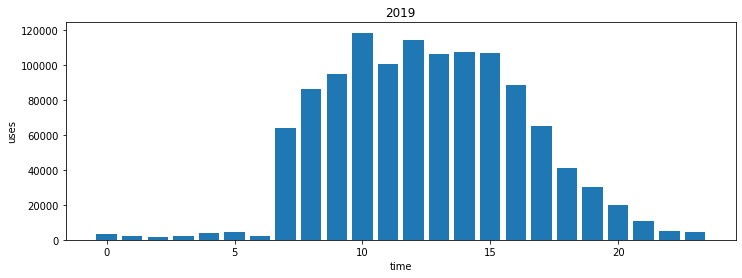

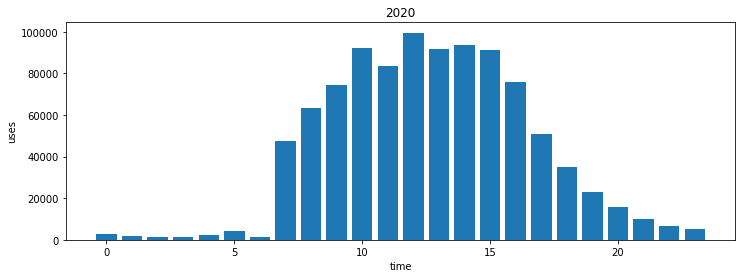

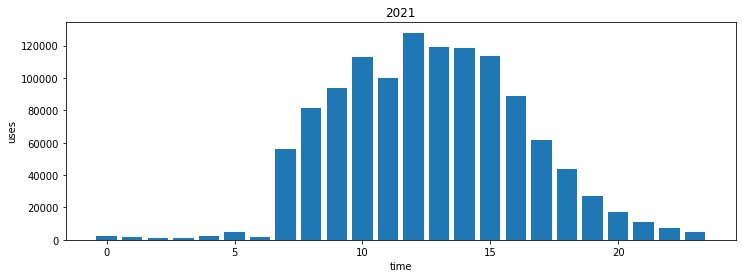

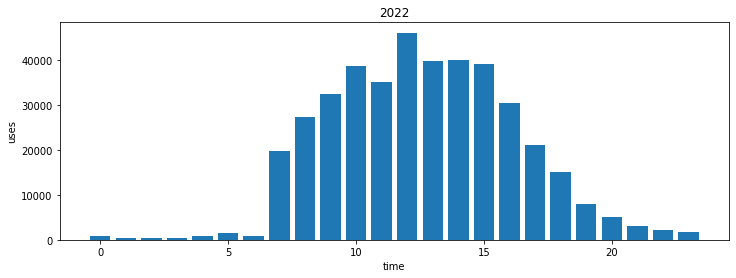

In [45]:
# 시간대별 승차 건수
for index, df in enumerate(data):
  # 시간형 데이터들이 object 형태로 읽혀서 다시 시간형 데이터로 변환
  for i in ['예정일시', '배차일시', '승차일시']:
    df[i] = pd.to_datetime(df[i])
  df['승차시간'] = df['승차일시'].apply(lambda x: x.hour)
  timeline = df.groupby('승차시간').count()['승차일시']

  plt.figure(figsize=(12, 4))
  plt.bar(timeline.index, timeline)
  plt.xlabel('time')
  plt.ylabel('uses')
  plt.title(f'{2019+index}')
  plt.show()

No handles with labels found to put in legend.


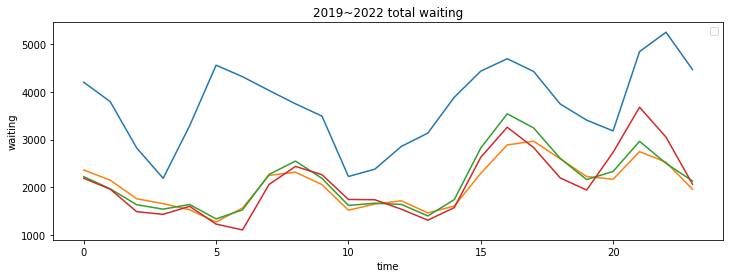

In [56]:
# 시간대별 대기 시간
plt.figure(figsize=(12, 4))
for index, df in enumerate(data):
  # 시간형 데이터들이 object 형태로 읽혀서 다시 시간형 데이터로 변환
  for i in ['예정일시', '배차일시', '승차일시']:
    df[i] = pd.to_datetime(df[i])
  
  df['승차-예정 시간'] = df['승차일시'] - df['예정일시']
  df['예정시간'] = df['예정일시'].apply(lambda x: x.hour)

  df = df[df['승차-예정 시간'] >= datetime.timedelta(seconds=0)]

  ydata = []
  for i in range(0, 24):
    temp = df[df['예정시간'] == i]
    ydata.append(temp['승차-예정 시간'].mean().total_seconds())
  
  x = np.arange(24)
  plt.plot(x, ydata)
plt.xlabel('time')
plt.ylabel('waiting')
plt.legend()
plt.title('2019~2022 total waiting')
plt.show()

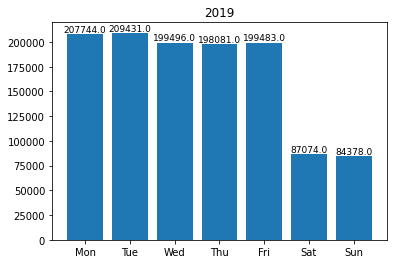

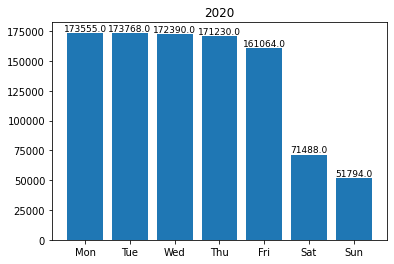

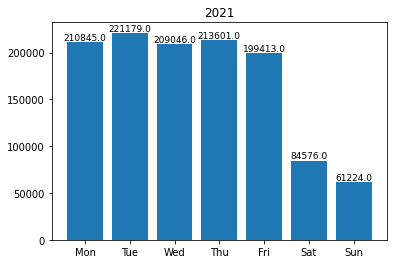

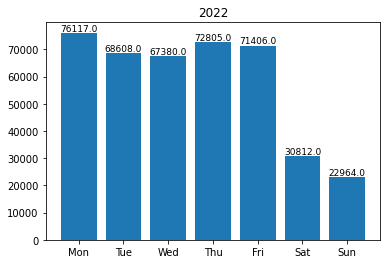

In [62]:
# 요일별 승차건수
for index, df in enumerate(data):
  df = df[['차량고유번호', '승차일시']]
  df['요일'] = df['승차일시'].apply(lambda x: x.weekday())
  week = 'Mon Tue Wed Thu Fri Sat Sun'.split()
  ydata = df.groupby('요일').count()['차량고유번호']
  plt.bar(week, ydata)

  for i in range(len(week)):
      height = ydata[i]
      plt.text(week[i], height + 0.25, '%.1f' %height, ha='center', va='bottom', size = 9)
  plt.title(f'{2019+index}')
  plt.show()

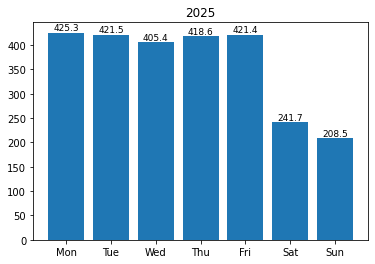

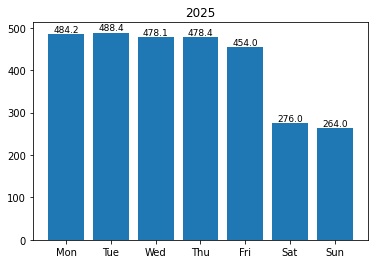

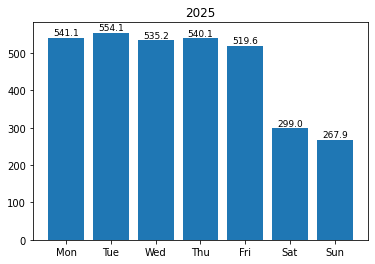

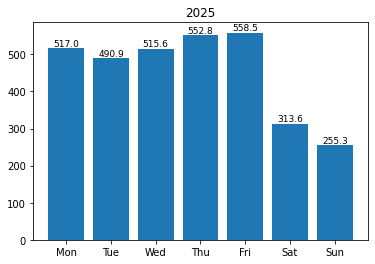

In [101]:
# 요일별 승차건수
for index, df in enumerate(data):
  df = df[['차량고유번호', '승차일시']]
  df['요일'] = df['승차일시'].apply(lambda x: x.weekday())
  week = 'Mon Tue Wed Thu Fri Sat Sun'.split()

  df['날짜'] = df['승차일시'].apply(lambda x: x.date())
  df2 = df.groupby(['날짜', '차량고유번호']).count().reset_index()
  df2['요일'] = df2['날짜'].apply(lambda x:x.weekday())
  df3 = df2.groupby(['날짜', '요일']).count()
  ydata = df3.groupby('요일').mean()['차량고유번호']
  plt.bar(week, ydata)

  for i in range(len(week)):
      height = ydata[i]
      plt.text(week[i], height + 0.25, '%.1f' %height, ha='center', va='bottom', size = 9)
  plt.title(f'{2019+i}')
  plt.show()

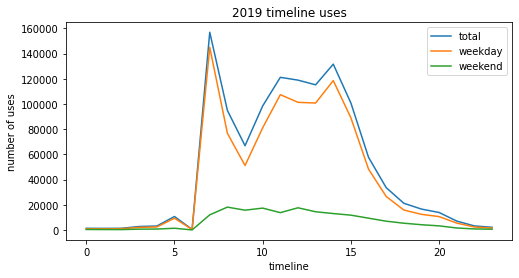

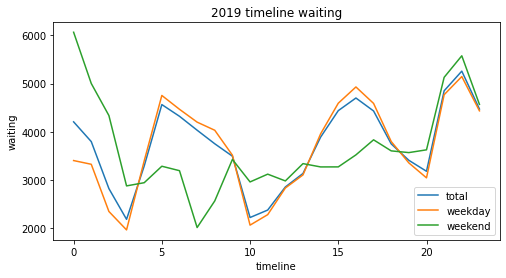

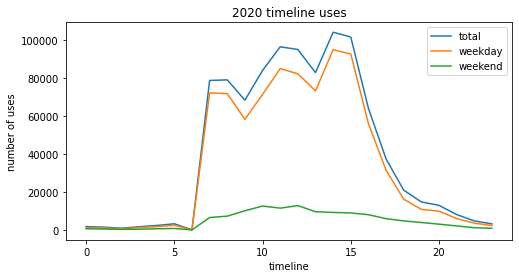

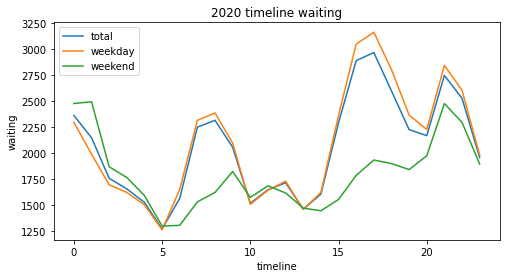

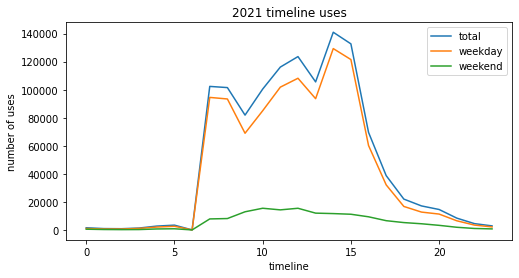

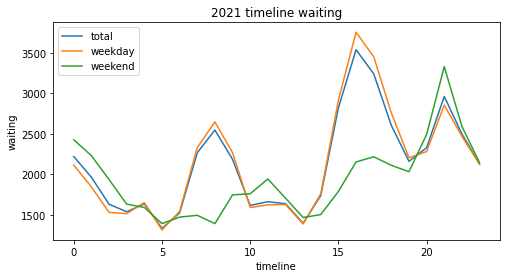

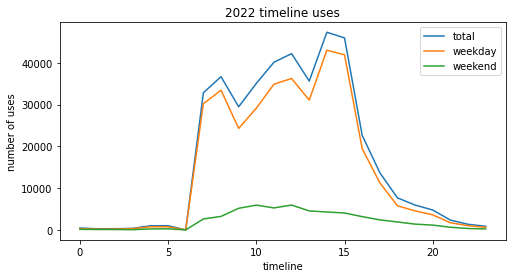

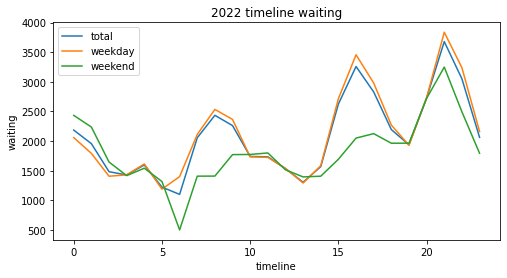

In [107]:
# 통합, 주중, 주말 나눠서 시간대별 승차량, 시간대별 대기시간 그래프
for index, df in enumerate(data):
  df['승차-예정 시간'] = df['승차일시'] - df['예정일시']
  # 예정 시간이 승차시간보다 빠른 불가능한 경우들 존재, 전부 제외
  df = df[df['승차-예정 시간'] >= datetime.timedelta(seconds=0)]

  df['예정시간'] = df['예정일시'].apply(lambda x: x.hour)
  # 요일, 주말 column 추가
  df['요일'] = df['예정일시'].apply(lambda x: x.weekday())
  df['주말'] = df['요일'].apply(lambda x: x >= 5)
  df_weekday = df[df['주말'] == False]
  df_weekend = df[df['주말']]

  # 시간대별 승차량
  plt.figure(figsize=(8, 4))
  df_timeline = df.groupby('예정시간').count()['요일']
  plt.plot(df_timeline.index, df_timeline, label='total')
  df_weekday_timeline = df_weekday.groupby('예정시간').count()['요일']
  plt.plot(df_weekday_timeline.index, df_weekday_timeline, label='weekday')
  df_weekend_timeline = df_weekend.groupby('예정시간').count()['요일']
  plt.plot(df_weekend_timeline.index, df_weekend_timeline, label='weekend')
  plt.xlabel('timeline')
  plt.ylabel('number of uses')
  plt.title(f'{2019+index} timeline uses')
  plt.legend()
  plt.show()
  # 시간대별 대기시간
  plt.figure(figsize=(8, 4))
  temp = df.groupby('예정시간')['승차-예정 시간'].mean().apply(lambda x: x.total_seconds())
  plt.plot(temp.index, temp, label='total')

  temp = df_weekday.groupby('예정시간')['승차-예정 시간'].mean().apply(lambda x: x.total_seconds())
  plt.plot(temp.index, temp, label='weekday')

  temp = df_weekend.groupby('예정시간')['승차-예정 시간'].mean().apply(lambda x: x.total_seconds())
  plt.plot(temp.index, temp, label='weekend')

  plt.xlabel('timeline')
  plt.ylabel('waiting')
  plt.title(f'{2019+index} timeline waiting')
  plt.legend()
  plt.show()